In [1]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn
!pip install imbalanced-learn  # SMOTE를 사용하기 위해 imbalanced-learn 설치
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.3 MB/s eta 0:00:00


In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict
from dtaidistance import dtw
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tslearn.metrics import dtw_path
from fastdtw import fastdtw
from imblearn.metrics import specificity_score

In [10]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [11]:
# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [12]:
from collections import defaultdict
from dtaidistance import dtw

# DTW 기반 데이터 증강 함수
def generate_dtw_synthetic_data(X, num_samples):
    synthetic_data = []

    for _ in range(num_samples):
        # 두 개의 랜덤 시계열 선택
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)
        a, b = X[idx1], X[idx2]

        # DTW Warping Path 계산
        path = dtw.warping_path(a, b)

        # a 시계열 기준 매칭된 b 값 평균 계산
        a_to_b_map = defaultdict(list)
        for i, j in path:
            a_to_b_map[i].append(b[j])

        a_mapped_values = []
        for i in range(len(a)):
            if i in a_to_b_map:
                avg_list = [(a[i] + b_j) / 2 for b_j in a_to_b_map[i]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = a[i]
            a_mapped_values.append(final_avg)

        # b 시계열 기준 매칭된 a 값 평균 계산
        b_to_a_map = defaultdict(list)
        for i, j in path:
            b_to_a_map[j].append(a[i])

        b_mapped_values = []
        for j in range(len(b)):
            if j in b_to_a_map:
                avg_list = [(b[j] + a_i) / 2 for a_i in b_to_a_map[j]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = b[j]
            b_mapped_values.append(final_avg)

        # 최종 증강 데이터: a 기반 평균과 b 기반 평균을 다시 평균화
        dtw_augmented = np.mean([a_mapped_values, b_mapped_values], axis=0)
        synthetic_data.append(dtw_augmented)

    return np.array(synthetic_data)

# 증강할 샘플 개수 설정
nCnt = len(X_train) - len(X_minority)

# DTW 기반 증강 데이터 생성
X_aug = generate_dtw_synthetic_data(X_minority, num_samples=nCnt)
y_aug = np.full(len(X_aug), minority_class)


# 원본 데이터와 합성 데이터 결합
X_synthetic = np.concatenate((X_train, X_aug), axis=0)
y_synthetic = np.concatenate((y_train, y_aug), axis=0)

In [13]:
# DTW 거리 계산 함수
def compute_dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

# X_train과 X_test 사이의 DTW 거리 계산하여 대칭 행렬로 표현
dtw_matrix = np.zeros((len(X_synthetic), len(X_test)))

# DTW 거리 계산
for i, train_series in enumerate(X_synthetic):
    for j, test_series in enumerate(X_test):
        distance = compute_dtw_distance(train_series, test_series)
        dtw_matrix[i, j] = distance

In [14]:
# 예측 함수 정의
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

In [15]:
# 예측 결과 저장
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test)
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:49:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Logistic Regression 성능 평가:
정확도: 0.6434
F1-Score: 0.7450
Recall: 0.8498
specificity: 0.3163
혼동 행렬 (Confusion Matrix):
[[105 227]
 [ 79 447]]


CART 성능 평가:
정확도: 0.6807
F1-Score: 0.7690
Recall: 0.8669
specificity: 0.3855
혼동 행렬 (Confusion Matrix):
[[128 204]
 [ 70 456]]


KNN 성능 평가:
정확도: 0.7448
F1-Score: 0.8136
Recall: 0.9087
specificity: 0.4849
혼동 행렬 (Confusion Matrix):
[[161 171]
 [ 48 478]]


XGBoost 성능 평가:
정확도: 0.7296
F1-Score: 0.8144
Recall: 0.9677
specificity: 0.3524
혼동 행렬 (Confusion Matrix):
[[117 215]
 [ 17 509]]


LSTM 성능 평가:
정확도: 0.6061
F1-Score: 0.6982
Recall: 0.7433
specificity: 0.3886
혼동 행렬 (Confusion Matrix):
[[129 203]
 [135 391]]


CNN 성능 평가:
정확도: 0.6841
F1-Score: 0.7791
Recall: 0.9087
specificity: 0.3283
혼동 행렬 (Confusion Matrix):
[[109 223]
 [ 48 478]]




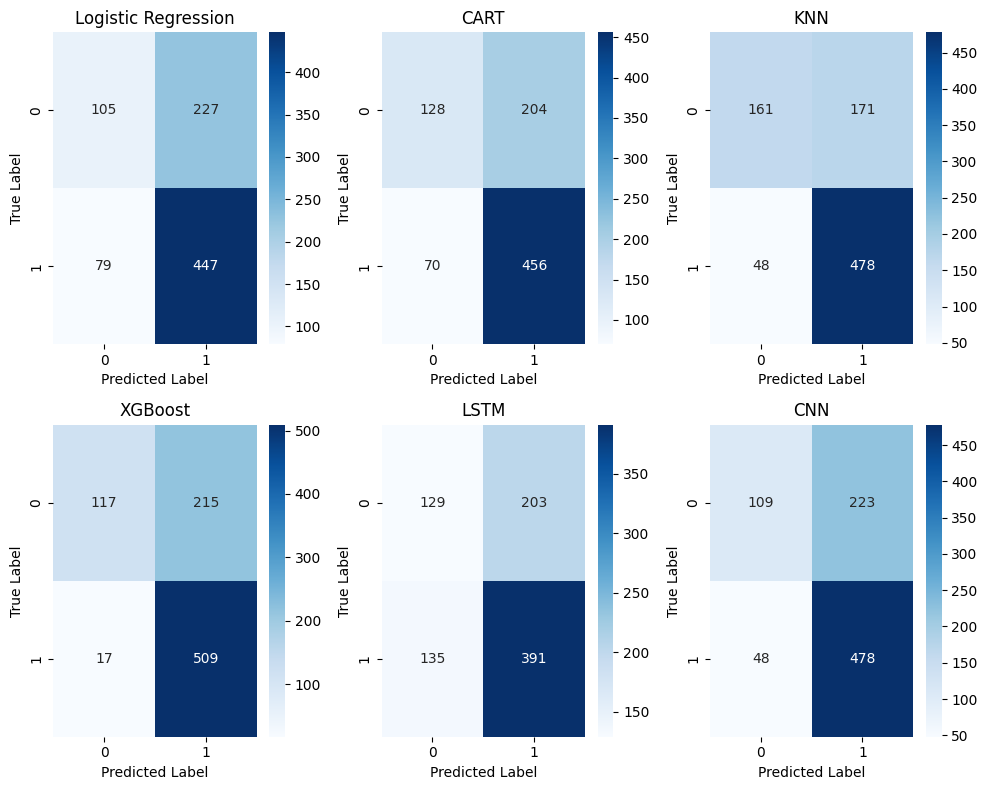

In [19]:
# 성능 평가
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"{model_name} 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)
    print("\n")

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
for model_name, pred_y in predictions.items():
    cm = confusion_matrix(y_test, pred_y)
    plt.subplot(2, 3, list(predictions.keys()).index(model_name) + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(model_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()